In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
from helper.lazy_regression import TooLazyForRegression
from helper.feature_extract import extract_highest_amplitude_features_with_mp
from helper.plot import plot_predictions_to_nearest_class_heatmap
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from scipy.stats import yeojohnson
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.metrics import confusion_matrix
from helper.plot import plot_error_per_cat

In [2]:
#Import data
df_mpa = pd.read_table('../data/data_mpa.txt', sep=' ')
df_mpa = extract_highest_amplitude_features_with_mp(df=df_mpa, create_one_sensor_feature=True, n_processes=4, keep_columns=False,verbose=False)
df_mpa = df_mpa[df_mpa['start_time'].str.contains('2021')]
df_mpa = df_mpa.drop(["start_time","packnr","velocity"], axis=1)
df_spg = pd.read_table('../data/data_spg.txt', sep=' ')
df_spg = extract_highest_amplitude_features_with_mp(df=df_spg, create_one_sensor_feature=True, n_processes=4, keep_columns=False,verbose=False)
df_spg = df_spg[df_spg['start_time'].str.contains('2021')]
df_spg = df_spg.drop(["start_time","packnr","velocity"], axis=1)
df_sps = pd.read_table('../data/data_sps.txt', sep=' ')
df_sps = extract_highest_amplitude_features_with_mp(df=df_sps, create_one_sensor_feature=True, n_processes=4, keep_columns=False,verbose=False)
df_sps = df_sps[df_sps['start_time'].str.contains('2021')]
df_sps = df_sps.drop(["start_time","packnr","velocity"], axis=1)

INFO || Extracting Max Features for types: ['M02', 'M01', 'M04', 'M03']
INFO || Extracting Max Features for types: ['G02', 'G01']
INFO || Extracting Max Features for types: ['S01']
INFO || Extracting Max Features for types: ['M01']
INFO || Extracting Max Features for types: ['G02', 'G01']


In [3]:
def transformer(df,X_log=False,y_log=False,cols = None):
    data = df.copy()
    if  X_log == False and y_log== True:
        data["size_mm"] = np.log1p(data["size_mm"])
        return data
    elif X_log == True and y_log== False:
        data= np.log1p(data)
        data[cols] = np.exp(data[cols])-1
        data["size_mm"] = np.exp(data["size_mm"])-1
        return data
    elif X_log == True and y_log== True:
        data= np.log1p(data)
        data[cols] = np.exp(data[cols])-1
        return data
    else:
        data = data
        return data

In [4]:
mpa_cols = (df_mpa.loc[:, df_mpa.columns.str.contains('freq')]).columns
spg_cols = (df_spg.loc[:, df_spg.columns.str.contains('freq')]).columns
sps_cols = (df_sps.loc[:, df_sps.columns.str.contains('freq')]).columns

In [5]:
df_mpa_log_X = transformer(df_mpa,X_log=True,y_log=False,cols=mpa_cols)
df_spg_log_X = transformer(df_spg,X_log=True,y_log=False,cols=spg_cols)
df_sps_log_X = transformer(df_sps,X_log=True,y_log=False,cols=sps_cols)

In [15]:
def confusion_compare(df,random_state=None,title='Confusion Matrix'):
    X, y = df.drop(['size_mm'], axis=1), df['size_mm']
    y =y.astype(np.str)
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=random_state)
    model = CatBoostRegressor(verbose=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("R2-Score:",r2_score(y_pred,y_test))
    classes = np.sort(df['size_mm'].unique())
    between_classes = [0]
    for i in range(len(classes)-1):
        b_c = (classes[i] + (classes[i+1])) / 2
        between_classes.append(b_c)

    between_classes.append(200)
    class_pred = []

    for i in range(len(y_pred)): 
        number = 0
        for j in range(len(classes)):
            if between_classes[j] <= y_pred[i] < between_classes[j+1]:
                class_pred.append(classes[j])

    y_test_list =[float(i) for i in y_test]

    class_test = []

    for i in range(len(y_test_list)): 
        number = 0
        for j in range(len(classes)):
            if between_classes[j] <= y_test_list[i] < between_classes[j+1]:
                class_test.append(classes[j])


    products_list  = [np.array(y_test),y_pred,class_pred,class_test]
    df_y = pd.DataFrame (products_list).transpose()
    df_y.columns = ['y_test', 'y_pred', 'class_pred', 'class_test', ]
    df_y["class_pred_int"] = (df_y["class_pred"]).astype(int)
    df_y["class_test_int"] = (df_y["class_test"]).astype(int)


    conf_mat = confusion_matrix(y_true=df_y["class_test_int"], y_pred=df_y["class_pred_int"])

    fig = plt.subplots(figsize=(20, 10))
    p = sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=classes,yticklabels=classes, cmap="YlGnBu",annot_kws={"size": 20 })
    p.set_title(title,size=20)
    p.set_ylabel('True',size=20)
    p.set_xlabel('Predicted',size=20)
    p.tick_params(labelsize=15,labelrotation=0)
    plt.show()
    plot_error_per_cat(y_test=y_test.astype(float), y_pred=y_pred)

# MPA

R2-Score: 0.706249535774253


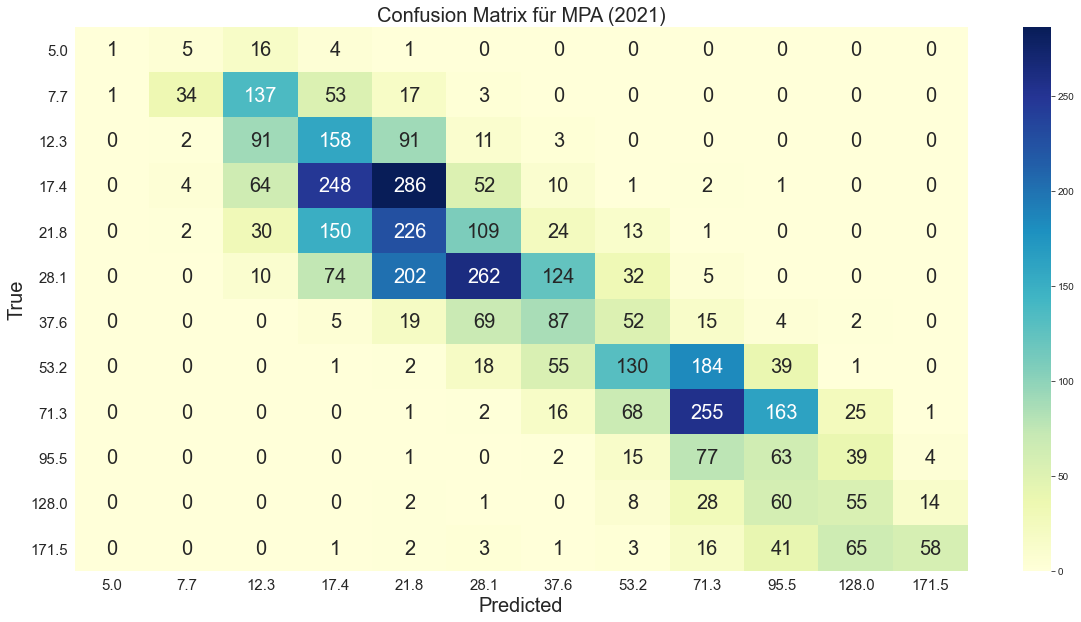

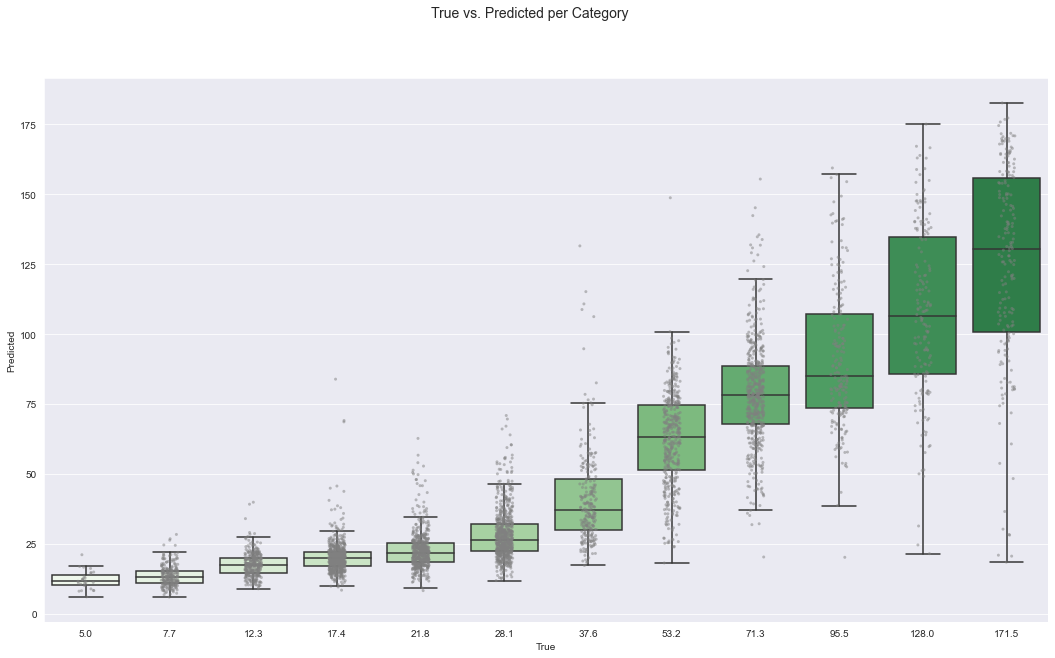

In [16]:
confusion_compare(df_mpa,random_state=None,title='Confusion Matrix für MPA (2021)')

# SPG

R2-Score: 0.7177275197012949


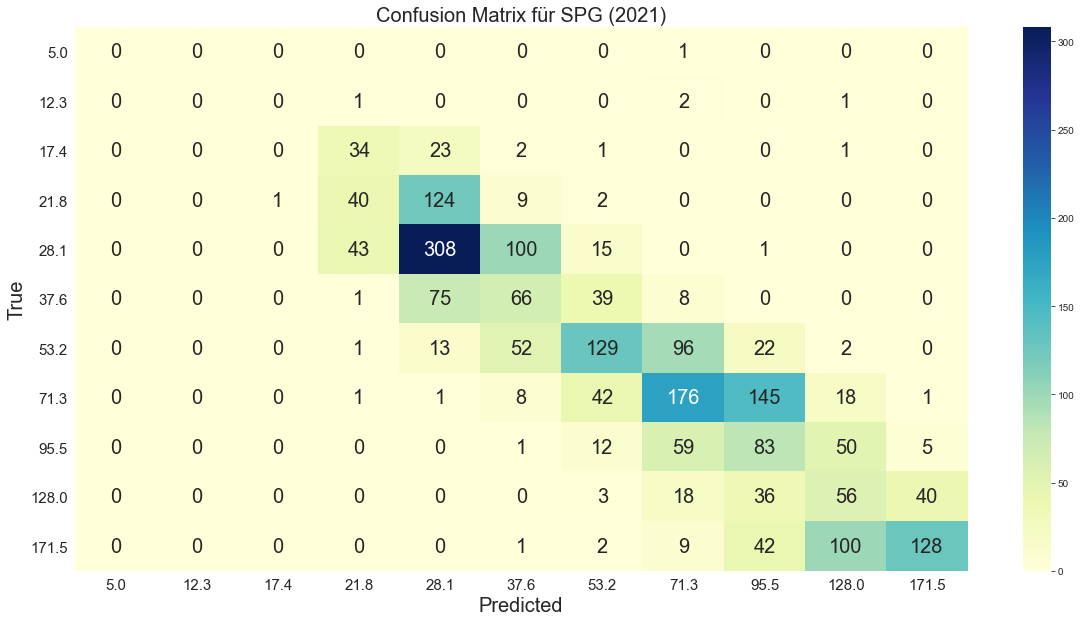

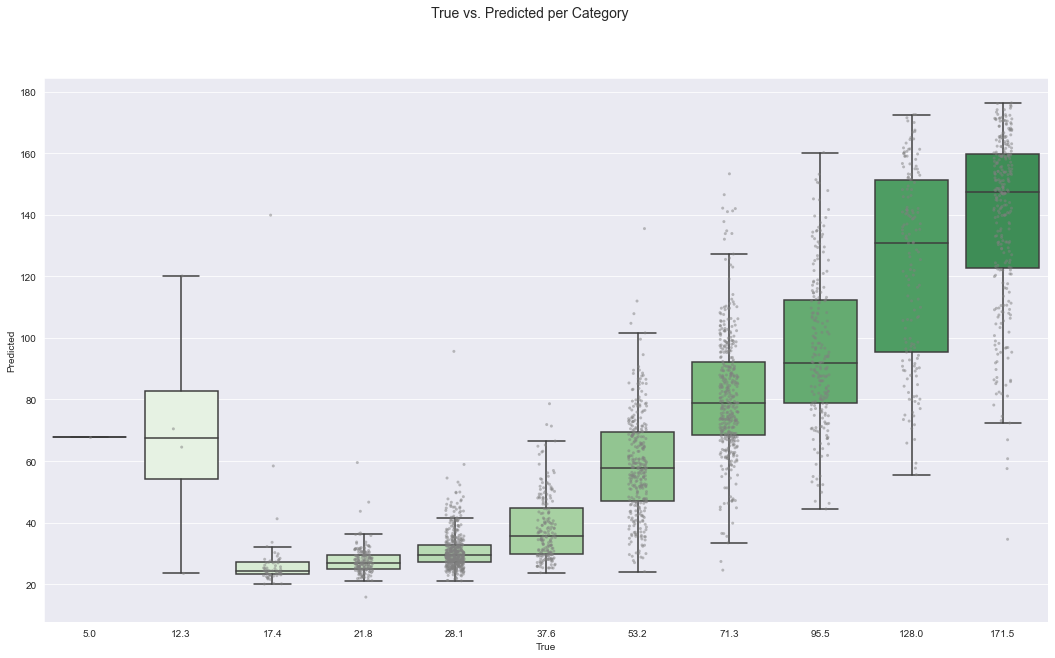

In [8]:
confusion_compare(df_spg,random_state=None,title='Confusion Matrix für SPG (2021)')

# SPS

R2-Score: 0.7244888886139685


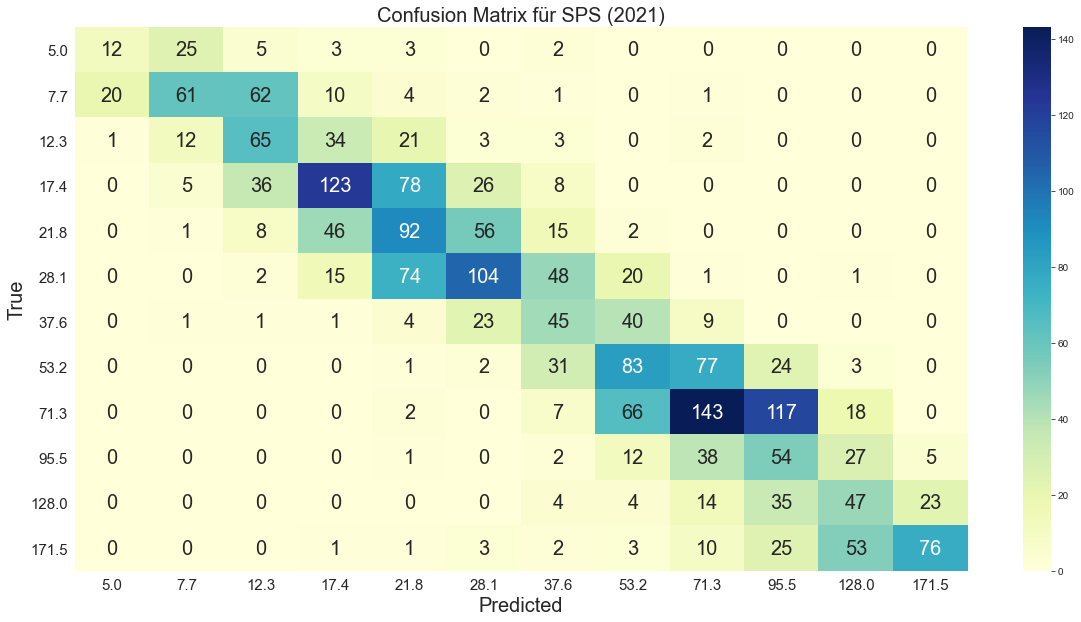

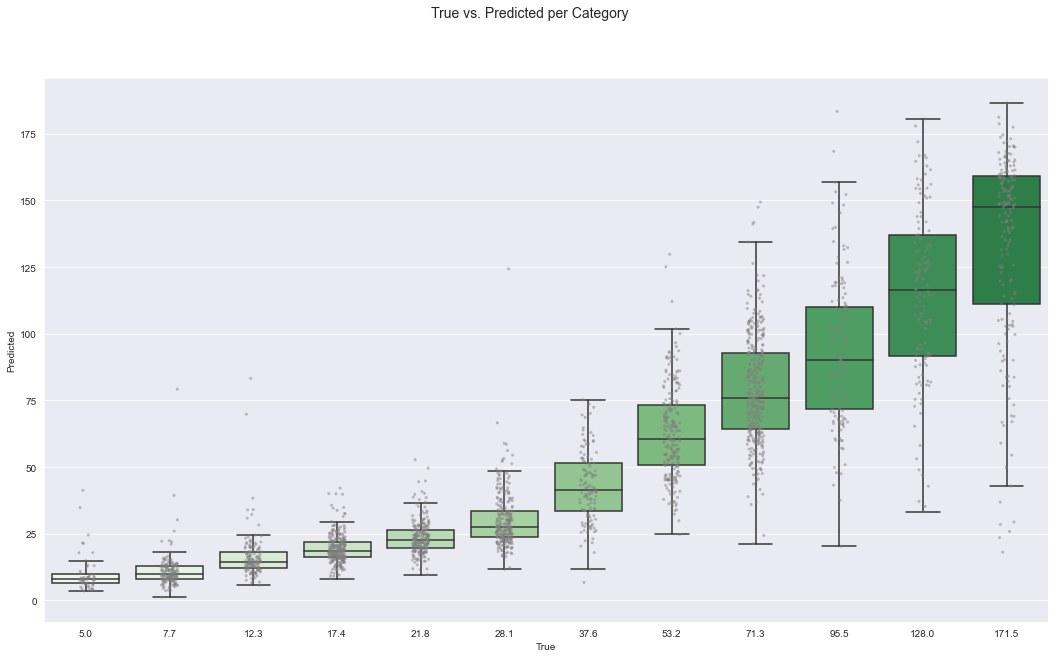

In [9]:
confusion_compare(df_sps,random_state=None,title='Confusion Matrix für SPS (2021)')